In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

C:\Users\milan\AppData\Local\Temp\ipykernel_15492\4239340261.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.



Using Dynamic Linear Model (DLM) to forecast...
Dynamic DLM Forecast Results:
Forecasted Total Damage for Next Year: 2930.75 million USD
95% Confidence Interval: [0, 9034.5] million USD


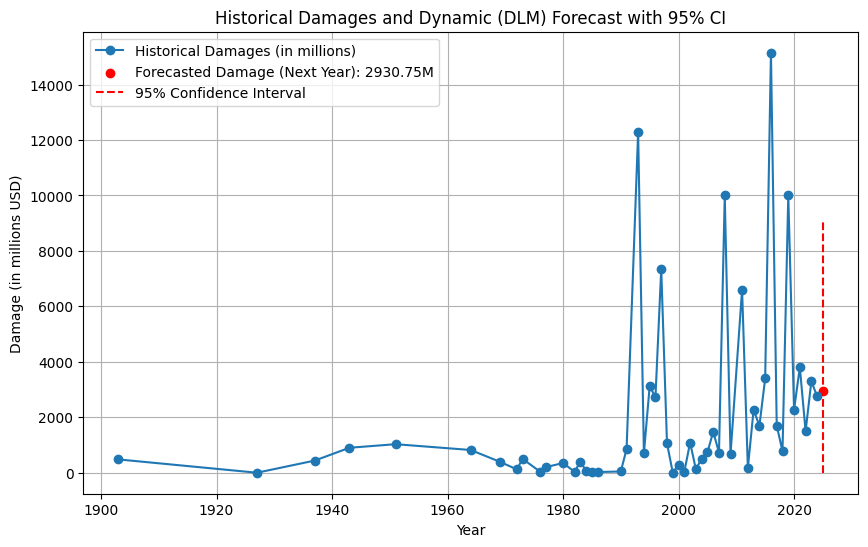

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality

# Load the Excel file containing the data
def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# Preprocessing function 
def preprocess_data(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) & (data['Disaster Type'] == disaster_type)]
    if filtered_data.empty:
        return None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    # Aggregate damages by year
    historical_data = filtered_data[['Year', 'Total Damage (\'000 US$)']].dropna()
    historical_data = historical_data.groupby('Year', as_index=False)['Total Damage (\'000 US$)'].sum()  # Sum damage per year
    historical_data['Total Damage (Millions)'] = historical_data['Total Damage (\'000 US$)'] / 1_000
    historical_data.set_index('Year', inplace=True)
    return historical_data

# Dynamic GLM model forecast function with 95% CI
def simulate_dynamic_glm(historical_data):
    try:
        y = historical_data['Total Damage (Millions)'].values

        # Define the DLM model
        model = dlm(y) + trend(degree=1, discount=0.95, name='trend') + seasonality(period=5, discount=0.99, name='5-year seasonality')
        
        # Fit the model
        model.fit()

        # Forecast the next point (next year) with variance for CI
        (forecast_mean, forecast_var) = model.predictN(N=1)

        # Calculate 95% CI (mean ± 1.96*stddev)
        std_dev = np.sqrt(forecast_var[0])
        lower_bound = max(0, forecast_mean[0] - 1.96 * std_dev)  
        upper_bound = forecast_mean[0] + 1.96 * std_dev

        return round(forecast_mean[0], 2), round(lower_bound, 2), round(upper_bound, 2), model
    except Exception as e:
        return f"Dynamic GLM model fitting failed: {e}", None, None, None

# Plot function for Dynamic GLM with 95% CI
def plot_dynamic_glm(historical_data, forecasted_value, lower, upper):
    next_year = historical_data.index.max() + 1

    plt.figure(figsize=(10, 6))
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], label="Historical Damages (in millions)", marker='o')
    plt.scatter(next_year, forecasted_value, color='red', label=f"Forecasted Damage (Next Year): {forecasted_value}M")
    plt.vlines(next_year, ymin=lower, ymax=upper, colors='red', linestyles='--', label="95% Confidence Interval")

    plt.title("Historical Damages and Dynamic (DLM) Forecast with 95% CI")
    plt.xlabel("Year")
    plt.ylabel("Damage (in millions USD)")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast function using DLM
def forecast_damage(file_path, country, disaster_type):
    data = load_data(file_path)
    if data is not None:
        historical_data = preprocess_data(data, country, disaster_type)
        if historical_data is None:
            print(f"No historical data available for {disaster_type} in {country}.")
            return

        print("\nUsing Dynamic Linear Model (DLM) to forecast...")

        forecasted_value, lower, upper, model = simulate_dynamic_glm(historical_data)
        if isinstance(forecasted_value, str):
            print(forecasted_value)
            return

        print(f"Dynamic DLM Forecast Results:")
        print(f"Forecasted Total Damage for Next Year: {forecasted_value} million USD")
        print(f"95% Confidence Interval: [{lower}, {upper}] million USD")

        plot_dynamic_glm(historical_data, forecasted_value, lower, upper)

# Main program
if __name__ == "__main__":
    file_path = "All Data.xlsx"
    country = input("Enter the country (ISO code, e.g., 'USA'): ").strip().upper()
    disaster_type = input("Enter the disaster type (e.g., 'Storm'): ").strip()
    forecast_damage(file_path, country, disaster_type)
